In [1]:
!pip install imutils

# Imports

In [2]:
import cv2
import os
import numpy as np
import pandas as pd
from imutils import paths
# import tensorflow
import tensorflow as tf

print(tf.__version__)

2.6.4


# Setting dataset directory

In [3]:
data_dir = '/kaggle/input/covid19-image-dataset/Covid19-dataset'

In [4]:
for dirpath, dirnames, filenames in os.walk(data_dir+'/train/'):
    print(f"There are {dirpath.split('/')[-1]} directory = {len(filenames)} .")
print()    
for dirpath, dirnames, filenames in os.walk(data_dir+'/test/'):
    print(f"There are {dirpath.split('/')[-1]} directory = {len(filenames)} .")    

There are  directory = 0 .
There are Normal directory = 70 .
There are Viral Pneumonia directory = 70 .
There are Covid directory = 111 .

There are  directory = 0 .
There are Normal directory = 20 .
There are Viral Pneumonia directory = 20 .
There are Covid directory = 26 .


## Visualize images from each class

In [5]:
covid_path = list(paths.list_images(os.path.join(data_dir,'train/Covid')))
pnumonia_path = list(paths.list_images(os.path.join(data_dir,'train/Viral Pneumonia')))
normal_path = list(paths.list_images(os.path.join(data_dir,'train/Normal')))

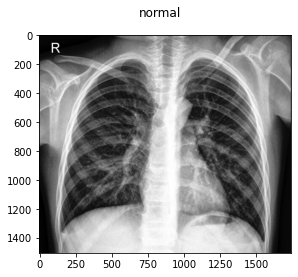

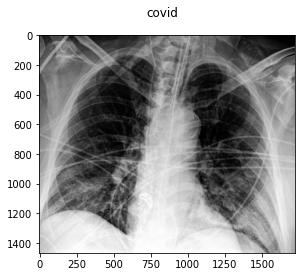

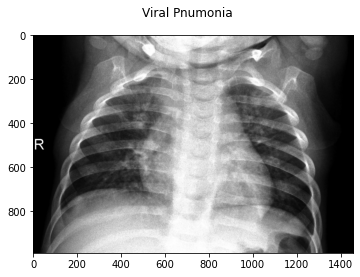

In [6]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
fig = plt.figure()
fig.suptitle('normal')
plt.imshow(mpimg.imread(normal_path[0]), cmap='gray')

fig = plt.figure()
fig.suptitle('covid')
plt.imshow(mpimg.imread(covid_path[0]), cmap='gray')

fig = plt.figure()
fig.suptitle('Viral Pnumonia')
plt.imshow(mpimg.imread(pnumonia_path[0]), cmap='gray')

# Preprocessing

In [7]:
BATCH_SIZE: int = 1
EPOCHS: int = 15
IMAGE_SIZE = (1000, 1000)
AUGMENTATION_FACTOR: float = 0.2
LABEL_MODE: str = "categorical"
TRAIN_DIR: str = "/kaggle/input/covid19-image-dataset/Covid19-dataset/train"
TEST_DIR: str = "/kaggle/input/covid19-image-dataset/Covid19-dataset/test"
RANDOM_SEED: int = 42

In [8]:
class_names = os.listdir(TRAIN_DIR)

In [9]:
print("Training data :")
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory=TRAIN_DIR,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    label_mode=LABEL_MODE,
    seed=RANDOM_SEED,
    shuffle=True,
)

print("Testing data :")
test_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory=TEST_DIR,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    label_mode=LABEL_MODE,
    seed=RANDOM_SEED,
    shuffle=False,
)

Training data :
Found 251 files belonging to 3 classes.


2022-12-12 11:03:19.475960: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Testing data :
Found 66 files belonging to 3 classes.


### Image Data Augmentation

In [10]:
from tensorflow.keras.layers import RandomFlip, RandomZoom, RandomRotation, RandomHeight, RandomWidth, Dense, Rescaling
from tensorflow.keras import Sequential
from tensorflow.keras.activations import softmax
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

In [11]:
augmentation_layer = Sequential([
    RandomFlip("horizontal", seed=RANDOM_SEED),
    RandomRotation(AUGMENTATION_FACTOR, seed=RANDOM_SEED),
    RandomZoom(AUGMENTATION_FACTOR, seed=RANDOM_SEED),
    RandomHeight(AUGMENTATION_FACTOR, seed=RANDOM_SEED),
    RandomWidth(AUGMENTATION_FACTOR, seed=RANDOM_SEED),
    Rescaling(1/255.)
], name="augmentation_layer")

# Model Building

## Create Base Model MobileNetV2

In [12]:
# Turn off all warnings except for errors
tf.get_logger().setLevel('ERROR')

base_model = tf.keras.applications.MobileNetV2(include_top=False)
base_model.trainable = False

# Input layer
input_layer = tf.keras.layers.Input(shape=IMAGE_SIZE + (3, ), name="input_layer")

x = augmentation_layer(input_layer)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling2d")(x)
x = Dense(300, activation='relu')(x)
output_layer = Dense(len(class_names), activation='softmax', name="output_layer")(x)

model_1 = tf.keras.Model(input_layer, output_layer)

9420800/9406464 [==============================] - 0s 0us/step


## Compile Model

In [31]:
model_1.compile(
    loss=CategoricalCrossentropy(),
    optimizer='rmsprop',
    metrics=["accuracy"]
)

In [32]:
modelcheckpoint_directory_path: str = "checkpoint_weights/checkpoint.cpk"

modelcheckpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=modelcheckpoint_directory_path,
    monitor=f"val_accuracy",
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", # watch the val acc metric
                                                  patience=3) # if val_accuracy decreases for 3 epochs in a row, stop training

reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_accuracy",  
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2,
                                                 verbose=1, # print out when learning rate goes down 
                                                 min_lr=1e-5)

In [33]:
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
    """
    Creates a TensorBoard callback instand to store log files.

    Stores log files with the filepath:
      "dir_name/experiment_name/current_datetime/"

    Args:
      dir_name: target directory to store TensorBoard log files
      experiment_name: name of experiment directory (e.g. efficientnet_model_1)
    """
    log_dir = dir_name + "/" + experiment_name + "/" + \
        datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(
        log_dir=log_dir
    )
    print(f"Saving TensorBoard log files to: {log_dir}")
    return tensorboard_callback

In [34]:
model_1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 1000, 1000, 3)]   0         
_________________________________________________________________
augmentation_layer (Sequenti (None, None, None, 3)     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, None, None, 1280)  2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 300)               384300    
_________________________________________________________________
output_layer (Dense)         (None, 3)                 903       
Total params: 2,643,187
Trainable params: 385,203
Non-trainable params: 2,257,984
_____________________________________________

## Fit Model

In [35]:
!mkdir -p history && touch history/history.csv

In [36]:
# Turn off all warnings except for errors
tf.get_logger().setLevel('ERROR')

history_1 = model_1.fit(
    train_data,
    epochs=EPOCHS,
    steps_per_epoch=len(train_data),
    validation_data=test_data,
    validation_steps=int(0.15 * len(test_data)),
    callbacks=[
        tf.keras.callbacks.CSVLogger("history/history.csv", append=True),
        modelcheckpoint_callback,
        create_tensorboard_callback(dir_name="tensorboard", experiment_name="covid19"),
        early_stopping_callback,
        reduce_lr_callback
    ]
)

Saving TensorBoard log files to: tensorboard/covid19/20221212-111653


2022-12-12 11:16:53.194752: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-12-12 11:16:53.195039: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-12-12 11:16:53.195696: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/15
  1/251 [..............................] - ETA: 20:50 - loss: 0.1571 - accuracy: 1.0000

2022-12-12 11:16:58.434711: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-12-12 11:16:58.434934: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


  2/251 [..............................] - ETA: 1:54 - loss: 2.7956 - accuracy: 0.5000 

2022-12-12 11:16:59.301853: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-12-12 11:16:59.312754: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-12-12 11:16:59.322776: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: tensorboard/covid19/20221212-111653/train/plugins/profile/2022_12_12_11_16_59

2022-12-12 11:16:59.327825: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to tensorboard/covid19/20221212-111653/train/plugins/profile/2022_12_12_11_16_59/332f5e9d22f8.trace.json.gz
2022-12-12 11:16:59.345691: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: tensorboard/covid19/20221212-111653/train/plugins/profile/2022_12_12_11_16_59

2022-12-12 11:16:59.348015: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to tensorboard/covid19

 25/251 [=>............................] - ETA: 1:27 - loss: 0.5303 - accuracy: 0.8000

Cleanup called...


 33/251 [==>...........................] - ETA: 1:22 - loss: 0.4812 - accuracy: 0.7879

Cleanup called...


 34/251 [===>..........................] - ETA: 1:21 - loss: 0.4670 - accuracy: 0.7941

Cleanup called...


 44/251 [====>.........................] - ETA: 1:15 - loss: 0.3657 - accuracy: 0.8409

Cleanup called...


 57/251 [=====>........................] - ETA: 1:08 - loss: 0.3016 - accuracy: 0.8596

Cleanup called...


126/251 [==============>...............] - ETA: 44s - loss: 0.2688 - accuracy: 0.8810

Cleanup called...


216/251 [========================>.....] - ETA: 12s - loss: 0.3238 - accuracy: 0.8843

Cleanup called...


224/251 [=========================>....] - ETA: 9s - loss: 0.3173 - accuracy: 0.8839

Cleanup called...


251/251 [==============================] - ETA: 0s - loss: 0.3270 - accuracy: 0.8845

Cleanup called...
Cleanup called...
Cleanup called...


251/251 [==============================] - 95s 362ms/step - loss: 0.3270 - accuracy: 0.8845 - val_loss: 0.1611 - val_accuracy: 0.8889

Epoch 00001: val_accuracy improved from -inf to 0.88889, saving model to checkpoint_weights/checkpoint.cpk
Epoch 2/15
 25/251 [=>............................] - ETA: 1:17 - loss: 0.3838 - accuracy: 0.7600

Cleanup called...


 33/251 [==>...........................] - ETA: 1:14 - loss: 0.3007 - accuracy: 0.8182

Cleanup called...


 34/251 [===>..........................] - ETA: 1:14 - loss: 0.3118 - accuracy: 0.8235

Cleanup called...


 44/251 [====>.........................] - ETA: 1:10 - loss: 0.2455 - accuracy: 0.8636

Cleanup called...


 57/251 [=====>........................] - ETA: 1:06 - loss: 0.2150 - accuracy: 0.8772

Cleanup called...


126/251 [==============>...............] - ETA: 42s - loss: 0.2928 - accuracy: 0.8810

Cleanup called...


216/251 [========================>.....] - ETA: 11s - loss: 0.2649 - accuracy: 0.9028

Cleanup called...


225/251 [=========================>....] - ETA: 8s - loss: 0.2603 - accuracy: 0.9067

Cleanup called...


251/251 [==============================] - ETA: 0s - loss: 0.2720 - accuracy: 0.8964

Cleanup called...
Cleanup called...
Cleanup called...


251/251 [==============================] - 88s 347ms/step - loss: 0.2720 - accuracy: 0.8964 - val_loss: 0.1085 - val_accuracy: 0.8889

Epoch 00002: val_accuracy did not improve from 0.88889
Epoch 3/15
 25/251 [=>............................] - ETA: 1:25 - loss: 0.1698 - accuracy: 0.9600

Cleanup called...


 33/251 [==>...........................] - ETA: 1:20 - loss: 0.2336 - accuracy: 0.9394

Cleanup called...


 34/251 [===>..........................] - ETA: 1:20 - loss: 0.2268 - accuracy: 0.9412

Cleanup called...


 44/251 [====>.........................] - ETA: 1:15 - loss: 0.1759 - accuracy: 0.9545

Cleanup called...


 57/251 [=====>........................] - ETA: 1:09 - loss: 0.2285 - accuracy: 0.9123

Cleanup called...


126/251 [==============>...............] - ETA: 43s - loss: 0.2452 - accuracy: 0.9048

Cleanup called...


216/251 [========================>.....] - ETA: 12s - loss: 0.2226 - accuracy: 0.9213

Cleanup called...


225/251 [=========================>....] - ETA: 9s - loss: 0.2138 - accuracy: 0.9244

Cleanup called...


251/251 [==============================] - ETA: 0s - loss: 0.2707 - accuracy: 0.9163

Cleanup called...
Cleanup called...
Cleanup called...


251/251 [==============================] - 89s 355ms/step - loss: 0.2707 - accuracy: 0.9163 - val_loss: 0.0838 - val_accuracy: 1.0000

Epoch 00003: val_accuracy improved from 0.88889 to 1.00000, saving model to checkpoint_weights/checkpoint.cpk
Epoch 4/15
 25/251 [=>............................] - ETA: 1:18 - loss: 0.1177 - accuracy: 0.9600

Cleanup called...


 33/251 [==>...........................] - ETA: 1:17 - loss: 0.1146 - accuracy: 0.9697

Cleanup called...


 34/251 [===>..........................] - ETA: 1:19 - loss: 0.1113 - accuracy: 0.9706

Cleanup called...


 44/251 [====>.........................] - ETA: 1:14 - loss: 0.1302 - accuracy: 0.9545

Cleanup called...


 57/251 [=====>........................] - ETA: 1:08 - loss: 0.1838 - accuracy: 0.9474

Cleanup called...


126/251 [==============>...............] - ETA: 42s - loss: 0.1994 - accuracy: 0.9365

Cleanup called...


216/251 [========================>.....] - ETA: 11s - loss: 0.2420 - accuracy: 0.9306

Cleanup called...


224/251 [=========================>....] - ETA: 9s - loss: 0.2363 - accuracy: 0.9330

Cleanup called...


251/251 [==============================] - ETA: 0s - loss: 0.2719 - accuracy: 0.9163

Cleanup called...
Cleanup called...
Cleanup called...


251/251 [==============================] - 88s 349ms/step - loss: 0.2719 - accuracy: 0.9163 - val_loss: 0.0520 - val_accuracy: 1.0000

Epoch 00004: val_accuracy did not improve from 1.00000
Epoch 5/15
 25/251 [=>............................] - ETA: 1:18 - loss: 0.2861 - accuracy: 0.8400

Cleanup called...


 33/251 [==>...........................] - ETA: 1:16 - loss: 0.2194 - accuracy: 0.8788

Cleanup called...


 34/251 [===>..........................] - ETA: 1:16 - loss: 0.2129 - accuracy: 0.8824

Cleanup called...


 44/251 [====>.........................] - ETA: 1:11 - loss: 0.1649 - accuracy: 0.9091

Cleanup called...


 57/251 [=====>........................] - ETA: 1:08 - loss: 0.1867 - accuracy: 0.9123

Cleanup called...


126/251 [==============>...............] - ETA: 41s - loss: 0.1615 - accuracy: 0.9286

Cleanup called...


216/251 [========================>.....] - ETA: 11s - loss: 0.1927 - accuracy: 0.9259

Cleanup called...


224/251 [=========================>....] - ETA: 9s - loss: 0.1884 - accuracy: 0.9286

Cleanup called...


251/251 [==============================] - ETA: 0s - loss: 0.2113 - accuracy: 0.9243

Cleanup called...
Cleanup called...
Cleanup called...


251/251 [==============================] - 88s 349ms/step - loss: 0.2113 - accuracy: 0.9243 - val_loss: 0.1911 - val_accuracy: 0.8889

Epoch 00005: val_accuracy did not improve from 1.00000

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 6/15
 25/251 [=>............................] - ETA: 1:15 - loss: 0.1443 - accuracy: 0.9200

Cleanup called...


 33/251 [==>...........................] - ETA: 1:12 - loss: 0.1123 - accuracy: 0.9394

Cleanup called...


 34/251 [===>..........................] - ETA: 1:12 - loss: 0.1090 - accuracy: 0.9412

Cleanup called...


 44/251 [====>.........................] - ETA: 1:09 - loss: 0.1793 - accuracy: 0.9318

Cleanup called...


 57/251 [=====>........................] - ETA: 1:03 - loss: 0.1426 - accuracy: 0.9474

Cleanup called...


126/251 [==============>...............] - ETA: 42s - loss: 0.0696 - accuracy: 0.9762

Cleanup called...


216/251 [========================>.....] - ETA: 11s - loss: 0.0715 - accuracy: 0.9769

Cleanup called...


224/251 [=========================>....] - ETA: 9s - loss: 0.0691 - accuracy: 0.9777

Cleanup called...


251/251 [==============================] - ETA: 0s - loss: 0.0775 - accuracy: 0.9761

Cleanup called...
Cleanup called...
Cleanup called...


251/251 [==============================] - 87s 347ms/step - loss: 0.0775 - accuracy: 0.9761 - val_loss: 0.1238 - val_accuracy: 0.8889

Epoch 00006: val_accuracy did not improve from 1.00000


## Evaluating 

In [37]:
evaluation_1 = model_1.evaluate(test_data)
evaluation_1

Cleanup called...


 7/66 [==>...........................] - ETA: 14s - loss: 0.1563 - accuracy: 0.8571

Cleanup called...


 8/66 [==>...........................] - ETA: 14s - loss: 0.1379 - accuracy: 0.8750

Cleanup called...


66/66 [==============================] - 17s 239ms/step - loss: 0.1099 - accuracy: 0.9242


[0.1099395602941513, 0.9242424368858337]

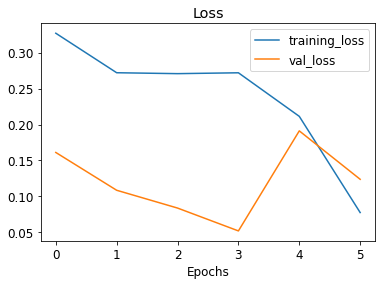

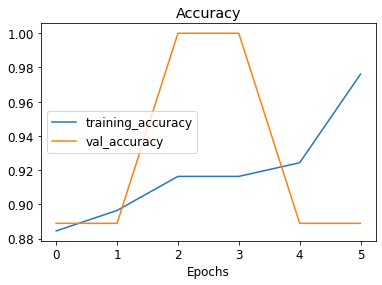

In [38]:
loss = history_1.history['loss']
val_loss = history_1.history['val_loss']

accuracy = history_1.history["accuracy"]
val_accuracy = history_1.history["val_accuracy"]

epochs = range(len(history_1.history['loss']))

# Plot loss
plt.plot(epochs, loss, label='training_loss')
plt.plot(epochs, val_loss, label='val_loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.legend()

# Plot accuracy
plt.figure()
plt.plot(epochs, accuracy, label='training_accuracy')
plt.plot(epochs, val_accuracy, label='val_accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.legend()

In [39]:
preds_probs = model_1.predict(test_data)
preds_probs[:10]

Cleanup called...
Cleanup called...
Cleanup called...


array([[3.6912963e-01, 9.0295207e-03, 6.2184083e-01],
       [9.9999881e-01, 9.2566892e-11, 1.2095196e-06],
       [9.9989688e-01, 6.4168620e-10, 1.0305021e-04],
       [9.9992478e-01, 6.7928561e-08, 7.5068659e-05],
       [9.0724593e-01, 1.2274474e-04, 9.2631347e-02],
       [9.9999762e-01, 3.4508989e-09, 2.3712403e-06],
       [9.9997520e-01, 5.7848726e-09, 2.4790972e-05],
       [9.9134713e-01, 2.9040035e-05, 8.6238179e-03],
       [9.8884261e-01, 7.9402853e-05, 1.1077892e-02],
       [9.1377079e-01, 5.4084541e-08, 8.6229198e-02]], dtype=float32)

In [40]:
pred_classes = preds_probs.argmax(axis=1)
pred_classes[:10]

array([2, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [41]:
y_labels = []
for images, labels in test_data.unbatch():
    y_labels.append(labels.numpy().argmax())
y_labels[:10]

Cleanup called...
Cleanup called...
Cleanup called...


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [42]:
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_true=y_labels,
                                  y_pred=pred_classes)
sklearn_accuracy

0.9242424242424242

In [55]:
cm = confusion_matrix(y_labels, pred_classes)
print(cm)

[[23  1  2]
 [ 0 20  0]
 [ 0  2 18]]


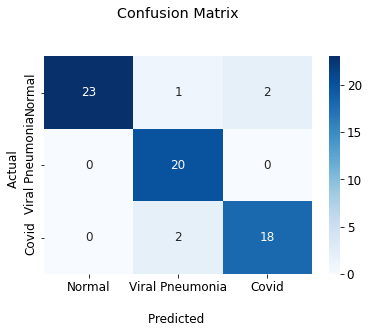

In [60]:
import seaborn as sns
ax = sns.heatmap(cm, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted ')
ax.set_ylabel('Actual  ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(class_names)
ax.yaxis.set_ticklabels(class_names)

## Display the visualization of the Confusion Matrix.
plt.show()

## Classification Report

In [62]:
from sklearn.metrics import classification_report
print(classification_report(y_labels,pred_classes,target_names=class_names))

                 precision    recall  f1-score   support

         Normal       1.00      0.88      0.94        26
Viral Pneumonia       0.87      1.00      0.93        20
          Covid       0.90      0.90      0.90        20

       accuracy                           0.92        66
      macro avg       0.92      0.93      0.92        66
   weighted avg       0.93      0.92      0.92        66



In [46]:
def load_and_prep_image(filename):
    """
    Reads in an image from filename, turns it into a tensor and reshapes into
    (224, 224, 3).

    Parameters
    ----------
    filename (str): string filename of target image
    img_shape (int): size to resize target image to, default 224
    scale (bool): whether to scale pixel values to range(0, 1), default True
    """
    # Read in the image
    img = tf.io.read_file(filename)
    # Decode it into a tensor
    img = tf.image.decode_jpeg(img, channels=3)
    # Resize the image
    img = tf.image.resize(img, list(IMAGE_SIZE))
    return img/255.

In [47]:
import random
def make_random_prediction(class_names, test_dir, qty: int = 3, figsize =(17, 10), fontsize: int = 12):
    plt.figure(figsize=figsize)
    for i in range(qty):
        # Choose random image(s) from random class(es)
        class_name = random.choice(class_names)
        filename = random.choice(os.listdir(test_dir + "/" + class_name))
        filepath = test_dir + "/" + class_name + "/" + filename
        
        # Load the image and make predictions
        print("filepath:", filepath)
        img = load_and_prep_image(filepath)
        print("before:", img.shape)
        img_expanded = tf.expand_dims(img, axis=0)
        print("after: ", img_expanded.shape)
        pred_prob = model_1.predict(img_expanded) # get prediction probabilities array
        pred_class = class_names[pred_prob.argmax()] # get highest prediction probability index and match it class_names list

        # Plot the image(s)
        plt.subplot(1, qty, i+1)
        # print(img)
        plt.imshow(img)
        if class_name == pred_class: # if predicted class matches truth class, make text green
            title_color = "g"
        else:
            title_color = "r"
        plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color, fontdict= {'fontsize': fontsize})
        plt.axis(False);

filepath: /kaggle/input/covid19-image-dataset/Covid19-dataset/test/Normal/0108.jpeg
before: (1000, 1000, 3)
after:  (1, 1000, 1000, 3)
filepath: /kaggle/input/covid19-image-dataset/Covid19-dataset/test/Covid/0111.jpg
before: (1000, 1000, 3)
after:  (1, 1000, 1000, 3)
filepath: /kaggle/input/covid19-image-dataset/Covid19-dataset/test/Normal/0103.jpeg
before: (1000, 1000, 3)
after:  (1, 1000, 1000, 3)


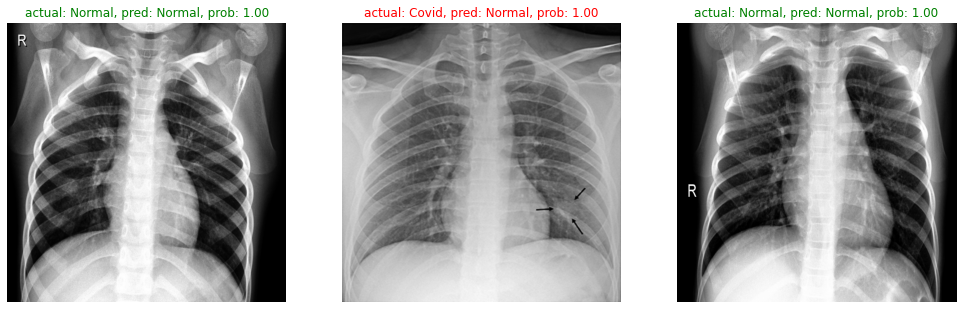

In [63]:
make_random_prediction(class_names, test_dir="/kaggle/input/covid19-image-dataset/Covid19-dataset/test")